# E_9 Chest X-ray  
=============
  
Î™©Ï∞®  
  
1. Î≤†Ïù¥Ïä§ ÎùºÏù∏  
2. VGG-16  
3. VGG+GAP  
4. Î≤†Ïù¥Ïä§ ÎùºÏù∏+tanh  
5. ResNets50

## 1. Î≤†Ïù¥Ïä§ ÎùºÏù∏  
-------------  

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìúÌï† Îïå Îπ†Î•¥Í≤å Î°úÎìúÌï† Ïàò ÏûàÎèÑÎ°ùÌïòÎäî ÏÑ§Ï†ï Î≥ÄÏàò
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶à Î≥ÄÏàò
IMAGE_SIZE = [180, 180]

# Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú Î≥ÄÏàò
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *ÏùÄ Î™®Îì† ÎîîÎ†âÌÜ†Î¶¨ÏôÄ ÌååÏùºÏùÑ ÏùòÎØ∏Ìï©ÎãàÎã§.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# ÌîÑÎ°úÏ†ùÌä∏Î•º ÏßÑÌñâÌï† Îïå ÏïÑÎûò Îëê Î≥ÄÏàòÎ•º Î≥ÄÍ≤ΩÌï¥Î≥¥ÏÑ∏Ïöî
BATCH_SIZE = 16
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train Îç∞Ïù¥ÌÑ∞ÏôÄ validation Îç∞Ïù¥ÌÑ∞Î•º Î™®Îëê filenamesÏóê Îã¥ÏäµÎãàÎã§
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# Î™®ÏïÑÏßÑ filenamesÎ•º 8:2Î°ú ÎÇòÎàïÎãàÎã§
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [26]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [24]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [11]:
# ÌååÏùº Í≤ΩÎ°úÏùò ÎÅùÏóêÏÑú ÎëêÎ≤àÏß∏ Î∂ÄÎ∂ÑÏùÑ ÌôïÏù∏ÌïòÎ©¥ ÏñëÏÑ±Í≥º ÏùåÏÑ±ÏùÑ Íµ¨Î∂ÑÌï† Ïàò ÏûàÏäµÎãàÎã§
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # ÌèêÎ†¥Ïù¥Î©¥ ÏñëÏÑ±(True), ÎÖ∏ÎßêÏù¥Î©¥ ÏùåÏÑ±(False)

In [13]:
# Ïù¥ÎØ∏ÏßÄÎ•º ÏïåÎßûÏùÄ ÌòïÏãùÏúºÎ°ú Î∞îÍøâÎãàÎã§.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # Ïù¥ÎØ∏ÏßÄÎ•º uint8 tensorÎ°ú ÏàòÏ†ï
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 ÌÉÄÏûÖÏúºÎ°ú ÏàòÏ†ï
    img = tf.image.resize(img, IMAGE_SIZE) # Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÎ•º IMAGE_SIZEÎ°ú ÏàòÏ†ï
    return img

# Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùò Í≤ΩÎ°úÎ•º ÏûÖÎ†•ÌïòÎ©¥ Ïù¥ÎØ∏ÏßÄÏôÄ ÎùºÎ≤®ÏùÑ ÏùΩÏñ¥ÏòµÎãàÎã§.
def process_path(file_path):
    label = get_label(file_path) # ÎùºÎ≤® Í≤ÄÏ∂ú
    img = tf.io.read_file(file_path) # Ïù¥ÎØ∏ÏßÄ ÏùΩÍ∏∞
    img = decode_img(img) # Ïù¥ÎØ∏ÏßÄÎ•º ÏïåÎßûÏùÄ ÌòïÏãùÏúºÎ°ú ÏàòÏ†ï
    return img, label

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [16]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [17]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

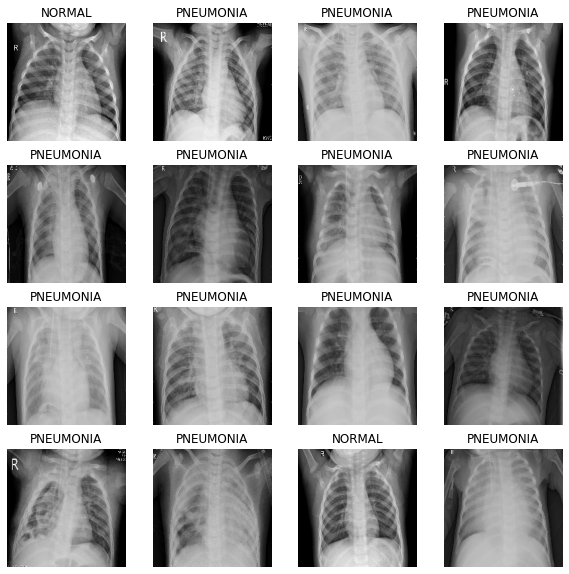

In [18]:
# Ïù¥ÎØ∏ÏßÄ Î∞∞ÏπòÎ•º ÏûÖÎ†•ÌïòÎ©¥ Ïó¨Îü¨Ïû•Ïùò Ïù¥ÎØ∏ÏßÄÎ•º Î≥¥Ïó¨Ï§çÎãàÎã§.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 62s 188ms/step - loss: 0.4097 - accuracy: 0.8113 - precision: 0.9441 - recall: 0.7933 - val_loss: 0.6965 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2248 - accuracy: 0.9176 - precision: 0.9746 - recall: 0.9132 - val_loss: 1.0555 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1914 - accuracy: 0.9258 - precision: 0.9771 - recall: 0.9217 - val_loss: 0.1976 - val_accuracy: 0.8981 - val_precision: 0.8792 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1807 - accuracy: 0.9315 - precision: 0.9753 - recall: 0.9313 - val_loss: 0.0656 - val_accuracy: 0.9779 - val_precision: 0.9831 - val_recall: 0.9869
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1683 - accura

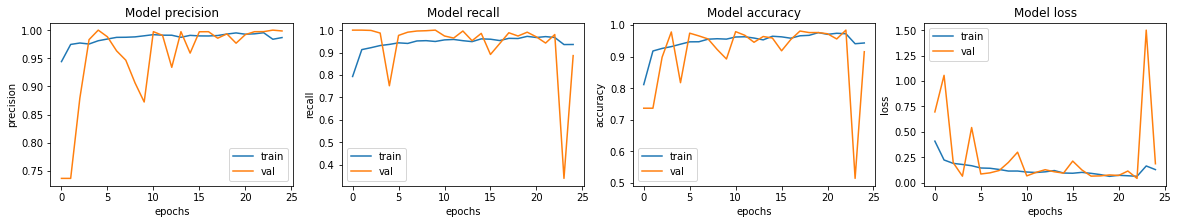

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 111ms/step - loss: 0.4352 - accuracy: 0.8670 - precision: 0.8753 - recall: 0.9179
Loss: 0.4351646304130554,
Accuracy: 0.8669871687889099,
Precision: 0.8753056526184082,
Recall: 0.9179487228393555


#### Î≤†Ïù¥Ïä§ÎùºÏù∏ Í≤∞Í≥º  
-------------  
  
ÌäπÎ≥ÑÌûà ÏÜêÎåÑ Í≤É ÏóÜÏù¥ Ïã§ÌñâÌñàÎçò Î™®Îç∏ÏóêÏÑú AccuracyÍ∞Ä 0.86Ïù¥ ÎÇòÏò§Í≤å ÎêêÎã§. Î£®Î∏åÎ¶≠ ÏßÄÌëúÎ•º Ïö∞Ïó∞Ïπò ÏïäÍ≤å ÎÑòÍ∏∞Í≤å ÎêòÏñ¥ ÎßåÏ°±Ïä§Îü¨ÏõÄ.  
Í∑∏Î†áÏßÄÎßå Îã§Î•∏ Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï¥Î≥¥Í≥† Ïã∂ÏùÄ ÎßàÏùåÏù¥ ÏÉùÍ≤®ÏÑú Îã§ÏñëÌïú Î™®Îç∏ÏùÑ ÏãúÌóòÌï¥ Î≥¥ÎèÑÎ°ù ÌïòÍ≤†Îã§.

## 2. VGG-16  
------------------

In [3]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìúÌï† Îïå Îπ†Î•¥Í≤å Î°úÎìúÌï† Ïàò ÏûàÎèÑÎ°ùÌïòÎäî ÏÑ§Ï†ï Î≥ÄÏàò
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶à Î≥ÄÏàò
IMAGE_SIZE = [180, 180]

# Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú Î≥ÄÏàò
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *ÏùÄ Î™®Îì† ÎîîÎ†âÌÜ†Î¶¨ÏôÄ ÌååÏùºÏùÑ ÏùòÎØ∏Ìï©ÎãàÎã§.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# ÌîÑÎ°úÏ†ùÌä∏Î•º ÏßÑÌñâÌï† Îïå ÏïÑÎûò Îëê Î≥ÄÏàòÎ•º Î≥ÄÍ≤ΩÌï¥Î≥¥ÏÑ∏Ïöî
BATCH_SIZE = 2
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train Îç∞Ïù¥ÌÑ∞ÏôÄ validation Îç∞Ïù¥ÌÑ∞Î•º Î™®Îëê filenamesÏóê Îã¥ÏäµÎãàÎã§
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# Î™®ÏïÑÏßÑ filenamesÎ•º 8:2Î°ú ÎÇòÎàïÎãàÎã§
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
show = list(train_list_ds.as_numpy_iterator())[:10]
show

[b'/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person346_virus_709.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1746_bacteria_4585.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person548_bacteria_2297.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0955-0001.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1571_bacteria_4108.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0579-0001.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person976_bacteria_2901.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0516-0001.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0699-0001.jpeg']

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# ÌååÏùº Í≤ΩÎ°úÏùò ÎÅùÏóêÏÑú ÎëêÎ≤àÏß∏ Î∂ÄÎ∂ÑÏùÑ ÌôïÏù∏ÌïòÎ©¥ ÏñëÏÑ±Í≥º ÏùåÏÑ±ÏùÑ Íµ¨Î∂ÑÌï† Ïàò ÏûàÏäµÎãàÎã§
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # ÌèêÎ†¥Ïù¥Î©¥ ÏñëÏÑ±(True), ÎÖ∏ÎßêÏù¥Î©¥ ÏùåÏÑ±(False)
# Ïù¥ÎØ∏ÏßÄÎ•º ÏïåÎßûÏùÄ ÌòïÏãùÏúºÎ°ú Î∞îÍøâÎãàÎã§.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # Ïù¥ÎØ∏ÏßÄÎ•º uint8 tensorÎ°ú ÏàòÏ†ï
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 ÌÉÄÏûÖÏúºÎ°ú ÏàòÏ†ï
    img = tf.image.resize(img, IMAGE_SIZE) # Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÎ•º IMAGE_SIZEÎ°ú ÏàòÏ†ï
    return img

# Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùò Í≤ΩÎ°úÎ•º ÏûÖÎ†•ÌïòÎ©¥ Ïù¥ÎØ∏ÏßÄÏôÄ ÎùºÎ≤®ÏùÑ ÏùΩÏñ¥ÏòµÎãàÎã§.
def process_path(file_path):
    label = get_label(file_path) # ÎùºÎ≤® Í≤ÄÏ∂ú
    img = tf.io.read_file(file_path) # Ïù¥ÎØ∏ÏßÄ ÏùΩÍ∏∞
    img = decode_img(img) # Ïù¥ÎØ∏ÏßÄÎ•º ÏïåÎßûÏùÄ ÌòïÏãùÏúºÎ°ú ÏàòÏ†ï
    return img, label

In [9]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
for image, label in train_ds.take(10):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  False


In [11]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [12]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [13]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

def VGG_16model():
    img_input = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv1')(x)
    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv1')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv2')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3pool')(x)

    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv1')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv2')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5pool')(x)

    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x)
    x = layers.Dense(4096, activation='relu', name='fc2')(x)

    classes=1
    x = layers.Dense(classes, activation='softmax', name='predictions')(x) 
    model = keras.Model(name="VGG-16", inputs=img_input, outputs=x)

    return model

In [21]:
model = VGG_16model()

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "VGG-16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2conv1 (Conv2D)         (None, 90, 90, 128)       73856     
_________________________________________________________________
block2conv2 (Conv2D)         (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0    

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
2092/2092 [==============================] - 199s 91ms/step - loss: 0.7048 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 0.6872 - val_accuracy: 0.7352 - val_precision: 0.7352 - val_recall: 1.0000
Epoch 2/20
2092/2092 [==============================] - 190s 91ms/step - loss: 0.6934 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 0.6923 - val_accuracy: 0.7352 - val_precision: 0.7352 - val_recall: 1.0000
Epoch 3/20
2092/2092 [==============================] - 190s 91ms/step - loss: 0.6932 - accuracy: 0.7440 - precision: 0.7440 - recall: 1.0000 - val_loss: 0.6934 - val_accuracy: 0.7352 - val_precision: 0.7352 - val_recall: 1.0000
Epoch 4/20
2092/2092 [==============================] - 190s 91ms/step - loss: 0.6934 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 0.6949 - val_accuracy: 0.7361 - val_precision: 0.7361 - val_recall: 1.0000
Epoch 5/20
2092/2092 [==============================] - 190s 91ms/step - loss: 0.693

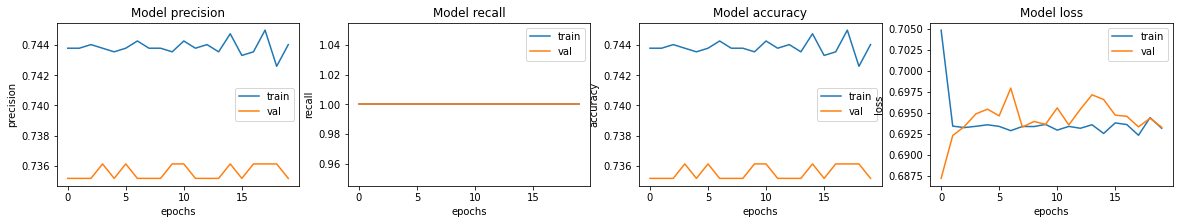

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

312/312 [==============================] - 5s 17ms/step - loss: 0.6932 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6932235360145569,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


#### VGG-16 Î™®Îç∏ Í≤∞Í≥º
----  
Ï†ïÎßêÏù¥ÏßÄ ÎÇòÎ•º ÍµâÏû•Ìûà ÌûòÎì§Í≤å ÌñàÎçò ÎÖÄÏÑùÏù¥ÏòÄÎã§. ÌååÎùºÎØ∏ÌÑ∞ÏàòÍ∞Ä ÏóÑÏ≤≠ ÎßéÏïÑÏÑú OOMÏù¥ ÎπµÎπµ ÌÑ∞Ï†∏ÎÇòÏôîÍ≥†, **Ïñ∏ÎèôÎãò**ÏóêÍ≤å Ï°∞Ïñ∏ÏùÑ Íµ¨Ìï¥ Î∞∞ÏπòÏÇ¨Ïù¥Ï¶àÎ•º Ï§ÑÏó¨ÏÑú Ìï¥Í≤∞Ìï¥ÏÑú Í∞ÑÏã†Ìûà Í≤∞Í≥ºÎ•º Î≥º Ïàò ÏûàÍ≤å ÎêòÏóàÎã§. Í∑∏Î†áÏßÄÎßå..
Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïòÏòÄÏùÑ Îïå recallÍ∞íÏù¥ 1Ïù¥ ÎÇòÏò§Îäî ÏÉÅÌô©Ïù¥ ÏÉùÍ≤ºÎã§. Î™áÎ≤àÏù¥Í≥† Ïû¨ÏãúÎèÑÎ•º Ìï¥Î≥¥ÏïòÏúºÎÇò Íæ∏Ï§ÄÌïòÍ≤å recallÏùÄ 1Îßå Î≥¥Ïó¨Ï£ºÎäî Î™®Îç∏Ïù¥ÏòÄÎã§. Í∑∏Ï†Ä ÌèêÎßå Î≥¥Ïù¥Î©¥ ÌèêÎ†¥Ïù¥ÎùºÍ≥† ÌïòÎäî ÎÖÄÏÑùÏù¥ ÎêòÎ≤ÑÎ¶∞ Ïù¥Ïú†Î•º ÏïåÏßÄ Î™ªÌï¥ÏÑú ÌïúÏ∞∏ÎèôÏïà Ïôú Ïù¥Îü∞Í≤∞Í≥ºÎ•º Î≥¥Ïó¨Ï£ºÎäî Í≤ÉÏù∏ÏßÄ Í≥†ÎØºÌï¥Î≥∏ Í≤∞Í≥º, MaxpoolingÏùò ÌöüÏàòÍ∞Ä ÎßéÏïÑ Îç∞Ïù¥ÌÑ∞Ïùò Î™®Îì† Í∞íÏù¥ Ìù∞ÏÉâÏóê Í∞ÄÍπåÏö¥ Í∞íÏùÑ Í∞ÄÏßÄÍ≤å ÎêòÏñ¥ Ïù¥Îü∞ ÌòÑÏÉÅÏù¥ Î∞úÏÉùÌïòÍ≤å Îêú Í≤ÉÏù¥ ÏïÑÎãêÍπå ÌïòÎäî ÏÉùÍ∞ÅÏù¥ Îì§ÏóàÍ≥†, GlobalaveragepoolingÏùÑ ÏÇ¨Ïö©Ìï¥Î≥¥Îäî Í≤ÉÏù¥ Ïñ¥ÎñªÍ≤†ÎÉêÎäî ÏïÑÏù¥ÎîîÏñ¥Î•º **ÏÑ†ÏïÑÎãò**üëçÍ≥º **Ïñ∏ÎèôÎãò**Ïù¥ Ï£ºÏÖîÏÑú ÏãúÎèÑÌï¥Î≥¥Í∏∞Î°ú ÌñàÎã§.

## 3. VGG+GAP
----

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
BATCH_SIZE = 16
EPOCHS = 20

def VGG_GAPmodel():
    img_input = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)

    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv1')(x)
    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv2')(x)

    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv1')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv2')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv3')(x)


    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv1')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv2')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv3')(x)
    x =layers.GlobalAveragePooling2D()(x)



    classes=1
    x = layers.Dense(classes, activation='sigmoid', name='predictions')(x) 
    model = keras.Model(name="VGG_GAP", inputs=img_input, outputs=x)

    return model

In [23]:
model = VGG_GAPmodel()

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "VGG_GAP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block2conv1 (Conv2D)         (None, 180, 180, 128)     73856     
_________________________________________________________________
block2conv2 (Conv2D)         (None, 180, 180, 128)     147584    
_________________________________________________________________
block3conv1 (Conv2D)         (None, 180, 180, 256)     295168    
_________________________________________________________________
block3conv2 (Conv2D)         (None, 180, 180, 256)     5900

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 123s 439ms/step - loss: 3.6290 - accuracy: 0.5115 - precision: 0.7519 - recall: 0.5141 - val_loss: 0.6950 - val_accuracy: 0.2462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
261/261 [==============================] - 116s 445ms/step - loss: 0.6921 - accuracy: 0.2548 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6947 - val_accuracy: 0.2923 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
261/261 [==============================] - 117s 449ms/step - loss: 0.6785 - accuracy: 0.5881 - precision: 0.7486 - recall: 0.6902 - val_loss: 0.6916 - val_accuracy: 0.7615 - val_precision: 0.7615 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 118s 451ms/step - loss: 0.7158 - accuracy: 0.3352 - precision: 0.6667 - recall: 0.1493 - val_loss: 0.6960 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
261/261 [==============================] - 11

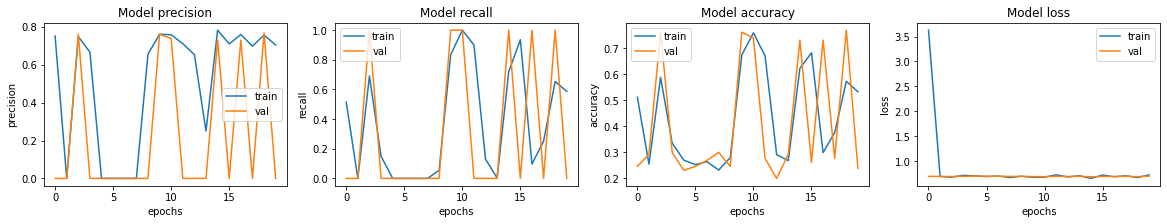

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

312/312 [==============================] - 49s 156ms/step - loss: 0.6951 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.6951078772544861,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


In [28]:
def VGG_GAPmodel():
    img_input = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)

    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv1')(x)
    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv2')(x)

    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv1')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv2')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv3')(x)


    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv1')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv2')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv3')(x)
    layers.GlobalAveragePooling2D()



    classes=1
    x = layers.Dense(classes, activation='softmax', name='predictions')(x) 
    model = keras.Model(name="VGG_GAP", inputs=img_input, outputs=x)

    return model

In [29]:
model2 = VGG_GAPmodel()

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "VGG_GAP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block2conv1 (Conv2D)         (None, 180, 180, 128)     73856     
_________________________________________________________________
block2conv2 (Conv2D)         (None, 180, 180, 128)     147584    
_________________________________________________________________
block3conv1 (Conv2D)         (None, 180, 180, 256)     295168    
_________________________________________________________________
block3conv2 (Conv2D)         (None, 180, 180, 256)     5900

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 127s 455ms/step - loss: 0.6888 - accuracy: 0.2510 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6955 - val_accuracy: 0.2231 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
261/261 [==============================] - 120s 461ms/step - loss: 0.6836 - accuracy: 0.2759 - precision: 0.7000 - recall: 0.0711 - val_loss: 0.6929 - val_accuracy: 0.7692 - val_precision: 0.7692 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 121s 462ms/step - loss: 0.6836 - accuracy: 0.7548 - precision: 0.7548 - recall: 1.0000 - val_loss: 0.6905 - val_accuracy: 0.7154 - val_precision: 0.7154 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 121s 462ms/step - loss: 0.7074 - accuracy: 0.6169 - precision: 0.7228 - recall: 0.7684 - val_loss: 0.6938 - val_accuracy: 0.2462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
261/261 [==============================] - 120s 462ms

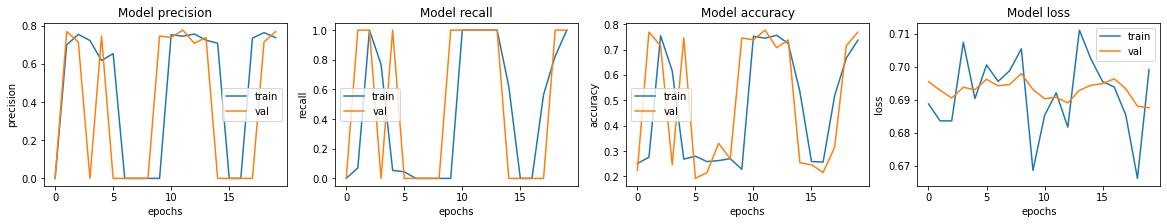

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

312/312 [==============================] - 50s 159ms/step - loss: 0.6906 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6905947327613831,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


#### VGG+GAP Í≤∞Í≥º
----  
ÎìúÎîîÏñ¥ Ïù¥Î≤àÏóêÎäî recallÍ∞íÏù¥ 1ÏóêÎßå Î®∏Î¨¥Î•¥Îäî ÏÉÅÌô©ÏùÄ Î≤óÏñ¥ÎÇòÍ≤å ÎêòÏóàÏúºÎÇò 0,1 Ïò§Í∞ÄÎ©∞ ÎÇòÌÉÄÎÇ¥Îäî Í≤∞Í≥ºÎ•º ÏñªÏóàÎã§. ÎßàÏßÄÎßâ Î†àÏù¥Ïñ¥Ïùò ÌôúÏÑ±Ìï®ÏàòÍ∞Ä sigmoidÍ∞Ä ÏïÑÎãå softmaxÎ•º Ïì∞Î©¥ ÌòπÏãúÎÇò Îã§Î•∏ Í≤∞Í≥ºÎ•º Î≥¥Ïó¨Ï£ºÏßÄ ÏïäÏùÑÍπåÌïòÎäî ÏÉùÍ∞ÅÏóê softmaxÎ°úÎèÑ Ìï¥Î¥§ÏßÄÎßå, Í∑∏Îü∞Í±∞ ÏóÜÏù¥ Í∑πÎã®Ï†ÅÏúºÎ°ú ÏõÄÏßÅÏù¥Îäî Í∑∏ÎûòÌîÑÎßå Î≥¥Ïó¨Ï§ÄÎã§. ÎÇ¥ Î™®Îç∏Ïùò recallÍ∞íÏùÄ Ïù¥ÏßÑÎ≤ïÏù¥ ÎêòÏñ¥Î≤ÑÎ†∏Îã§.. Ïó¨Í∏∞ÏÑú ÏÉùÍ∞ÅÌï¥Î≥¥Í≤å Îêú Í≤ÉÏùÄ Î†àÏù¥Ïñ¥Í∞Ä ÎÑàÎ¨¥ ÍπäÏñ¥ÏÑú gradient ÏÜåÏã§Ïù¥ ÏùºÏñ¥ÎÇòÎäîÍ±∏Íπå?? ÎùºÎäî ÏùòÎ¨∏Ïù¥ÏòÄÎã§. Í∑∏Îü¨Î©¥ÏÑú Î≤†Ïù¥Ïä§ ÎùºÏù∏Ïùò Î™®Îç∏ÏùÑ Î≥¥Îãà Î∞∞ÏπòÏ†ïÍ∑úÌôîÎèÑ Ìï¥Ï£ºÍ≥† ÎìúÎ°≠ÏïÑÏõÉÎèÑ Í∞ôÏù¥ ÏÇ¨Ïö©ÎêòÏóàÏóàÍ≥†, ÎÇ¥Í∞Ä Íµ¨ÏÑ±Ìïú Î™®Îç∏ÏóêÎäî Îëê Í∞ÄÏßÄ Î™®Îëê ÌïòÏßÄ ÏïäÏïòÏóàÎã§. ÏûòÎ™ªÎêòÏóàÏùåÏùÑ Íπ®Îã¨ÏùÄ ÏàúÍ∞ÑÏù¥ÏóàÏßÄÎßå ÎêòÎèåÎ¶¥ ÏàòÍ∞Ä ÏóÜÏóàÎçòÍ≤å ÏïÑÏâΩÎã§.

## 4. Î≤†Ïù¥Ïä§ Î™®Îç∏ + tanh  
----  


In [9]:
# train Îç∞Ïù¥ÌÑ∞ÏôÄ validation Îç∞Ïù¥ÌÑ∞Î•º Î™®Îëê filenamesÏóê Îã¥ÏäµÎãàÎã§
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# Î™®ÏïÑÏßÑ filenamesÎ•º 8:2Î°ú ÎÇòÎàïÎãàÎã§
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [39]:
# Ïù¥ÎØ∏ÏßÄÎ•º ÏïåÎßûÏùÄ ÌòïÏãùÏúºÎ°ú Î∞îÍøâÎãàÎã§.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=1) # Ïù¥ÎØ∏ÏßÄÎ•º uint8 tensorÎ°ú ÏàòÏ†ï
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 ÌÉÄÏûÖÏúºÎ°ú ÏàòÏ†ï
    img = (img -127.5) / 127.5
    img = tf.image.resize(img, IMAGE_SIZE) # Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÎ•º IMAGE_SIZEÎ°ú ÏàòÏ†ï
    return img

# Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùò Í≤ΩÎ°úÎ•º ÏûÖÎ†•ÌïòÎ©¥ Ïù¥ÎØ∏ÏßÄÏôÄ ÎùºÎ≤®ÏùÑ ÏùΩÏñ¥ÏòµÎãàÎã§.
def process_path(file_path):
    label = get_label(file_path) # ÎùºÎ≤® Í≤ÄÏ∂ú
    img = tf.io.read_file(file_path) # Ïù¥ÎØ∏ÏßÄ ÏùΩÍ∏∞
    img = decode_img(img) # Ïù¥ÎØ∏ÏßÄÎ•º ÏïåÎßûÏùÄ ÌòïÏãùÏúºÎ°ú ÏàòÏ†ï
    return img, label

In [40]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [41]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 1)
Label:  False


In [42]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [43]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [60]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [61]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [62]:
with tf.device('/GPU:0'):
    model_tanh = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_tanh.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [63]:
with tf.device('/GPU:0'):
    history = model_tanh.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
2092/2092 [==============================] - 59s 25ms/step - loss: 0.7227 - accuracy: 0.5038 - precision: 0.7495 - recall: 0.5000 - val_loss: 0.7575 - val_accuracy: 0.2639 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
2092/2092 [==============================] - 52s 25ms/step - loss: 0.7049 - accuracy: 0.4847 - precision: 0.7306 - recall: 0.4870 - val_loss: 0.7228 - val_accuracy: 0.2648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
2092/2092 [==============================] - 52s 25ms/step - loss: 0.6982 - accuracy: 0.4902 - precision: 0.7434 - recall: 0.4804 - val_loss: 0.7675 - val_accuracy: 0.2648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
2092/2092 [==============================] - 51s 25ms/step - loss: 0.6956 - accuracy: 0.5189 - precision: 0.7519 - recall: 0.5276 - val_loss: 0.7455 - val_accuracy: 0.2648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
2092/2092 [==============================] - 

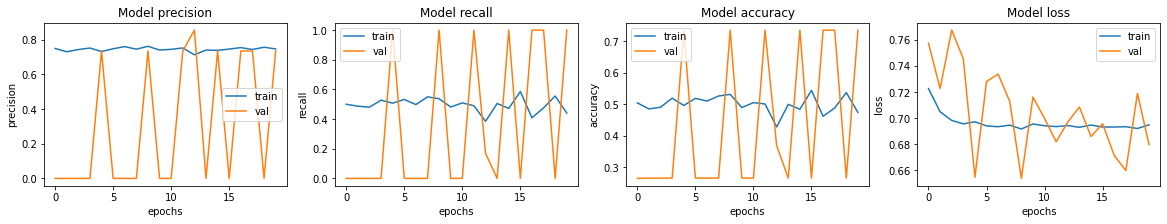

In [64]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [66]:
loss, accuracy, precision, recall = model_tanh.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

312/312 [==============================] - 4s 11ms/step - loss: 0.6862 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6861655116081238,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


#### Î≤†Ïù¥Ïä§ÎùºÏù∏ +tanh Í≤∞Í≥º  
----  
Ïù¥Î≤àÏóî Îç∞Ïù¥ÌÑ∞Î•º nomalizeÌïòÏó¨ Îç∞Ïù¥ÌÑ∞Ïùò Î≤îÏúÑÎ•º[-1, 1] ÏÇ¨Ïù¥Î°ú Ìï¥ÏÑú tanhÎ•º Ïç®Î≥¥Í≥†Ïûê ÌïòÏòÄÎã§.  
(ÏõêÎûò Í≥ÑÌöçÏùÄ ÎßàÏßÄÎßâÎ†àÏù¥Ïñ¥ÏóêÏÑú tanhÎ•º ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏù¥ÏòÄÏúºÎÇò, predictÏùò Î≤îÏúÑÍ∞Ä 0Í≥º 1ÏÇ¨Ïù¥Ïóê ÏûàÏñ¥ÏïºÌïúÎã§Îäî ÏóêÎü¨Í∞Ä Î∞úÏÉùÌïòÏó¨ Ìè¨Í∏∞ÌïòÏòÄÏùå. ÏßÄÍ∏à ÏÉùÍ∞ÅÌï¥Î≥¥Î©¥ Î°úÏä§Ìï®ÏàòÎ•º Î≥ÄÍ≤ΩÌï¥Î≥¥ÎäîÍ±¥ Ïñ¥Îï†ÏùÑÍπå Ïã∂Í∏∞ÎèÑ Ìï®.)  
Í∑∏Î¶¨Í≥† Í∏∞Ï°¥ Î≤†Ïù¥Ïä§ÎùºÏù∏ Î™®Îç∏ÏùÑ Í∞ÄÏ†∏ÏôÄ ÎìúÎ°≠ÏïÑÏõÉÍ≥º batch nomalizationÎèÑ ÏÇ¨Ïö©ÌïòÏòÄÎã§.  
Í∑∏ÎüºÏóêÎèÑ Î∂àÍµ¨ÌïòÍ≥† Ïù¥Î≤à Í∑∏ÎûòÌîÑ Ïó≠Ïãú ÏöîÎèôÏπòÎäî Í∑∏ÎûòÌîÑÎ•º ÏñªÍ≤å ÎêòÏóàÎã§ test Í≤∞Í≥ºÎäî Recall 1ÏúºÎ°ú  
Ïù¥Î≤àÏóêÎèÑ~ ÏÑ∏ÏÉÅ Î™®Îì† Ìèê ÏÇ¨ÏßÑÏùÄ ÌèêÎ†¥Ïù¥ÎùºÍ≥† ÎßêÌï¥Ï£ºÎäî Î™®Îç∏ÏùÑ ÎßåÎì§Í≤å ÎêòÏóàÎã§. tanhÎ°ú ÌôúÏÑ±Ìôî Ìïú ÌõÑÏóê Îã§Ïãú sigmoidÎ•º ÏÇ¨Ïö©Ìï†Í±∞ÏòÄÏúºÎ©¥ Ï∞®ÎùºÎ¶¨ nomalizeÎ•º [0, 1]Î≤îÏúÑÎ°ú ÌïòÍ≥† tanhÎ•º ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÎäîÍ≤å Ïñ¥Îï†ÏùÑÍπå? ÌïòÎäî ÏÉùÍ∞ÅÏù¥ Îì†Îã§.

## 5. ResNets50  
----

In [7]:
BATCH_SIZE = 2
EPOCHS = 30
# train Îç∞Ïù¥ÌÑ∞ÏôÄ validation Îç∞Ïù¥ÌÑ∞Î•º Î™®Îëê filenamesÏóê Îã¥ÏäµÎãàÎã§
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# Î™®ÏïÑÏßÑ filenamesÎ•º 8:2Î°ú ÎÇòÎàïÎãàÎã§
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [11]:
# ÌååÏùº Í≤ΩÎ°úÏùò ÎÅùÏóêÏÑú ÎëêÎ≤àÏß∏ Î∂ÄÎ∂ÑÏùÑ ÌôïÏù∏ÌïòÎ©¥ ÏñëÏÑ±Í≥º ÏùåÏÑ±ÏùÑ Íµ¨Î∂ÑÌï† Ïàò ÏûàÏäµÎãàÎã§
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # ÌèêÎ†¥Ïù¥Î©¥ ÏñëÏÑ±(True), ÎÖ∏ÎßêÏù¥Î©¥ ÏùåÏÑ±(False)
# Ïù¥ÎØ∏ÏßÄÎ•º ÏïåÎßûÏùÄ ÌòïÏãùÏúºÎ°ú Î∞îÍøâÎãàÎã§.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # Ïù¥ÎØ∏ÏßÄÎ•º uint8 tensorÎ°ú ÏàòÏ†ï
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 ÌÉÄÏûÖÏúºÎ°ú ÏàòÏ†ï
    img = tf.image.resize(img, IMAGE_SIZE) # Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÎ•º IMAGE_SIZEÎ°ú ÏàòÏ†ï
    return img

# Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùò Í≤ΩÎ°úÎ•º ÏûÖÎ†•ÌïòÎ©¥ Ïù¥ÎØ∏ÏßÄÏôÄ ÎùºÎ≤®ÏùÑ ÏùΩÏñ¥ÏòµÎãàÎã§.
def process_path(file_path):
    label = get_label(file_path) # ÎùºÎ≤® Í≤ÄÏ∂ú
    img = tf.io.read_file(file_path) # Ïù¥ÎØ∏ÏßÄ ÏùΩÍ∏∞
    img = decode_img(img) # Ïù¥ÎØ∏ÏßÄÎ•º ÏïåÎßûÏùÄ ÌòïÏãùÏúºÎ°ú ÏàòÏ†ï
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [15]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
resnet_model = keras.applications.resnet.ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=(180,180,3), pooling='avg', classes=1)
x = keras.layers.Dense(128, activation='relu')(resnet_model.output)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(resnet_model.input, x)

In [17]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 90, 90, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
2092/2092 [==============================] - 159s 57ms/step - loss: 0.5565 - accuracy: 0.7522 - precision: 0.9054 - recall: 0.7445 - val_loss: 0.4766 - val_accuracy: 0.7658 - val_precision: 0.8235 - val_recall: 0.8674
Epoch 2/30
2092/2092 [==============================] - 117s 56ms/step - loss: 0.3686 - accuracy: 0.8365 - precision: 0.9480 - recall: 0.8255 - val_loss: 0.3537 - val_accuracy: 0.8614 - val_precision: 0.8492 - val_recall: 0.9870
Epoch 3/30
2092/2092 [==============================] - 117s 56ms/step - loss: 0.3076 - accuracy: 0.8745 - precision: 0.9668 - recall: 0.8610 - val_loss: 0.3108 - val_accuracy: 0.8633 - val_precision: 0.9603 - val_recall: 0.8492
Epoch 4/30
2092/2092 [==============================] - 117s 56ms/step - loss: 0.2878 - accuracy: 0.8757 - precision: 0.9655 - recall: 0.8637 - val_loss: 0.3676 - val_accuracy: 0.8155 - val_precision: 0.9898 - val_recall: 0.7568
Epoch 5/30
2092/2092 [==============================] - 117s 56ms/step - loss: 0.240

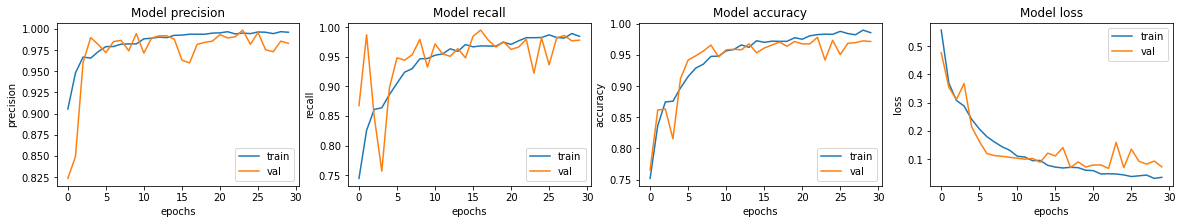

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

312/312 [==============================] - 7s 22ms/step - loss: 1.3726 - accuracy: 0.7692 - precision: 0.7330 - recall: 0.9923
Loss: 1.3726035356521606,
Accuracy: 0.7692307829856873,
Precision: 0.7329545617103577,
Recall: 0.9923076629638672


#### ResNets50 Í≤∞Í≥º  
----  
  
Ïù¥Î≤àÏóî kerasÏóê applicationÏúºÎ°ú Í≥µÍ∞úÎêòÏñ¥ ÏûàÎäî ResNets50 Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï¥Î≥¥ÏïòÎã§. Ï≤òÏùå Í≥ÑÌöçÏóî ÏóÜÏóàÏúºÎÇò **ÏÑ†ÏïÑÎãò**Ïùò Ïò§Î•òÌï¥Í≤∞ÏùÑ Ìï®Íªò Ìï¥Î≥¥Í≥†Ïûê ÏãúÏûëÌïòÍ≤å ÎêòÏóàÎã§. ÏÇ¨Ïã§ VGG-16Î™®Îç∏ÎèÑ applicationÏúºÎ°ú Í≥µÍ∞úÎêú Î™®Îç∏Ïù¥ ÏûàÏóàÏúºÎÇò, ÏÇ¨Ïö©Ïù¥ ÎØ∏ÏàôÌïòÏó¨ Í≥µÍ∞úÎêú Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïòÏßÄ Î™ªÌïòÍ≥† ÏßÅÏ†ë Î†àÏù¥Ïñ¥Î•º ÎßåÎì§ÏóàÎçò Í≤ÉÏù∏Îç∞, Ïù¥Î≤à ÏùµÏä§Î•º ÏßÑÌñâÌïòÎ©¥ÏÑú stackoverflowÏóê ÏûêÏ£º Í∞ÄÍ≤å ÎêòÍ≥†, Í∞ôÏùÄ Í≥†ÎØºÏùÑ ÌñàÎçò ÏÇ¨ÎûåÎì§Í≥º Í∑∏Ïóê ÎåÄÌïú Ìï¥Í≤∞Ï±ÖÏùÑ Ï£ºÎäî ÎßéÏùÄ Ïù¥Îì§Ïùò ÎåìÍ∏ÄÏùÑ Î≥¥Î©∞ Ìï¥Í≤∞Ï±ÖÏùÑ Ï∞æÎã§Î≥¥Îãà ResNetsÏùÄ Ïù¥Í≤ÉÏ†ÄÍ≤É Îí§Ï†ÅÍ±∞Î¶¨Î©∞ Î™®Îç∏ ÏÇ¨Ïö© Ìï¥Í≤∞Î∞©Î≤ïÏùÑ ÏñªÍ≤å ÎêòÏóàÎã§.  ÏÇ¨Ïö©ÌñàÎçò Î™®Îç∏ Ï§ë Ïú†ÏùºÌïòÍ≤å ÌïôÏäµ ÎêòÍ≥† ÏûàÎäî Î™®ÏñëÏùÑ Î≥¥Ïù¥Îäî Í∑∏ÎûòÌîÑÎ•º ÏñªÏùÑ Ïàò ÏûàÏóàÏúºÎ©∞, ÏóêÌè≠ÏùÑ ÏµúÎåÄ 40ÍπåÏßÄ Ìï¥Î¥§ÎäîÎç∞ 40Ïù¥ ÏµúÍ≥†Ïùò accuracyÎ•º Î≥¥Ïó¨Ï§¨Í≥†, Í∑∏ Îã§ÏùåÏù¥ ÌòÑÏû¨ ÏûàÎäî 30, Í∑∏Î¶¨Í≥† early stoppingÏùÑ ÏÇ¨Ïö©ÌñàÎçò ÏÇ¨Î°Ä ÏàúÏù¥Îã§. overfittingÏùÑ Í±±Ï†ïÌñàÏßÄÎßå ÏïÑÏßÅ Ï†úÎåÄÎ°ú ÌïôÏäµÎêòÏßÄ ÏïäÏùÄ ÏÉÅÌÉúÍ∞Ä ÏïÑÎãêÍπå ÌïòÎäî Ïú†Ï∂îÎ•º ÌïòÏòÄÍ≥†, ÏóêÌè≠ÏùÑ 100ÍπåÏßÄ ÎèåÎ†§Î≥¥Í≥† Ïã∂ÏóàÏúºÎÇò, 30ÏóêÌè≠ Ï°∞Ï∞® 1ÏãúÍ∞ÑÏù¥ Í±∏Î†§ÏÑú Ï†úÏ∂úÏãúÍ∞ÑÏù¥ ÌïúÏãúÍ∞Ñ ÎÇ®ÏùÄ ÏßÄÍ∏àÏùÄ Ìï¥Î≥º Ïàò ÏóÜÎäî ÏÉÅÌô©Ïù¥Îùº Í∞úÏù∏Ï†ÅÏúºÎ°ú ÎèÑÏ†ÑÌï¥Î≥¥ÎèÑÎ°ù Ìï† ÏòàÏ†ïÏù¥Îã§. ÌïôÏäµÎßå Ïûò ÎêúÎã§Î©¥ accuracy 0.9Ïù¥ÏÉÅÎèÑ ÎÖ∏Î†§Î≥º Ïàò ÏûàÏßÄ ÏïäÏùÑÍπå? ÎùºÎäî ÏÉùÍ∞ÅÏùÑ ÌïòÍ≤å ÎêòÏóàÍ≥†, Îçî ÎßéÏùÄ Í≥µÍ∞úÎ™®Îç∏Îì§ÏùÑ ÏÇ¨Ïö©Ìï¥Î≥¥Í≥† Ïã∂Ïñ¥Ï°åÎã§. 

## ÌöåÍ≥†  
----  
Îî•MLÏãúÍ∞ÑÍ≥º ÎÖ∏ÎìúÏóêÏÑú Î∞∞Ïõ†Îçò imagenetsÏóêÏÑú Ïö∞ÏàòÌïú ÏÑ±Ï†ÅÏùÑ Í±∞Îëî Î™®Îç∏Îì§ÏùÑ ÏÇ¨Ïö©Ìï¥Î≥¥Í≥† Ïã∂ÏùÄ ÎßàÏùåÏù¥ Îì§Ïñ¥ ÏßÑÌñâÌñàÎçò ÏùµÏä§Î°ú Î™®Îç∏ÏÇ¨Ïö©Ïóê ÎÑàÎ¨¥ ÏπòÏ§ëÌï¥ÏÑú Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨Î•º nomalizeÎ∞ñÏóê Ìï¥Î≥¥ÏßÄ Î™ªÌñàÎçò Í≤ÉÏù¥ ÏïÑÏâΩÍ≥†, ÏÑ±Îä•Ïù¥ Îçî Îõ∞Ïñ¥ÎÇú InceptionÏù¥ÎÇò NASNet Í∞ôÏùÄ Î™®Îç∏Îì§ÏùÑ ÏÇ¨Ïö©Ìï¥Î≥¥ÏßÄ Î™ªÌïú Í≤ÉÏù¥ ÏïÑÏâ¨ÏõÄÏù¥ ÎÇ®ÏïòÎã§.  
Ïó¨Îü¨ ÏãúÎèÑÎ•º Ìï¥Î≥¥Î©¥ÏÑú Î™®Îç∏ Íµ¨Ï∂ïÍ≥º ÏÇ¨Ïö©Î≤ïÏóê ÎåÄÌï¥ ÎßéÏùÄ Í≥µÎ∂ÄÍ∞Ä ÎêòÏóàÏúºÎÇò, Recall 1Ïù¥ ÎÇòÏò§Îäî Ïù¥Ïú†Î•º Í∏∞Ïö∏Í∏∞ ÏÜåÏã§Ïù¥ÎùºÍ≥† Ïú†Ï∂îÎßå Ìïú Ï±Ñ ÌôïÏù∏Ìï¥Î≥¥ÏßÄ Î™ªÌïú Í≤É ÎòêÌïú ÏïÑÏâ¨ÏõÄÏúºÎ°ú ÎÇ®ÎäîÎã§. VGGÎ™®Îç∏ÏóêÏÑú fc7Í≥ÑÏ∏µÏùò Ïª®ÌÖçÏä§Ìä∏Î≤°ÌÑ∞Î•º Î≥º Ïàò ÏûàÎã§Í≥† ÌïòÏòÄÎäîÎç∞ Ïã§Ï†úÎ°ú ÏãúÍ∞ÅÌôîÌïòÏó¨ ÌôïÏù∏ Ìï¥Î≥¥ÏßÄ Î™ªÌñàÎçò Í≤É ÎòêÌïú ÏïÑÏâΩÍ≤å ÎäêÍª¥ÏßÑÎã§.
